# Trajectories of the electrification of vehicles in the world

In this notebook, I try to look for an overarching pattern in the electrification of the worlds vehicle sales.

### Imports and various tests

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from utils import correlate_slice_normalized, df_shift_index
from IPython.display import display

%load_ext autoreload
%autoreload 2

import world_ev_data as ev

In [2]:
e_car_sales = ev.robbie_andrew_data()
e_car_sales

sales_bevs  Diesel  Ethanol  Ethanol_Petrol  Gasoline  \
Country YYYYMM                                                              
Albania 2019-01-01         1.0  2416.0      NaN             NaN       NaN   
        2019-02-01         1.0  2708.0      NaN             NaN       NaN   
        2019-03-01         3.0  1374.0      NaN             NaN       NaN   
        2019-04-01         2.0  2010.0      NaN             NaN       NaN   
        2019-05-01         0.0  2735.0      NaN             NaN       NaN   
...                        ...     ...      ...             ...       ...   
Uruguay 2025-03-01       475.0    37.0      NaN             NaN       NaN   
        2025-04-01       489.0    14.0      NaN             NaN       NaN   
        2025-05-01       594.0    25.0      NaN             NaN       NaN   
        2025-06-01       373.0    38.0      NaN             NaN       NaN   
        2025-07-01       601.0    24.0      NaN             NaN       NaN   

                    Hybrid  Hydrogen  ICE  InternalCombustion  LPG  ...  \
Country YYYYMM                                                      ...   
Albania 2019-01-01     NaN       NaN  NaN                 NaN  NaN  ...   
        2019-02-01     NaN       NaN  NaN                 NaN  NaN  ...   
        2019-03-01     NaN       NaN  NaN                 NaN  NaN  ...   
        2019-04-01     NaN       NaN  NaN                 NaN  NaN  ...   
        2019-05-01     NaN       NaN  NaN                 NaN  NaN  ...   
...                    ...       ...  ...                 ...  ...  ...   
Uruguay 2025-03-01   165.0       NaN  NaN                 NaN  NaN  ...   
        2025-04-01    50.0       NaN  NaN                 NaN  NaN  ...   
        2025-05-01    24.0       NaN  NaN                 NaN  NaN  ...   
        2025-06-01    31.0       NaN  NaN                 NaN  NaN  ...   
        2025-07-01   210.0       NaN  NaN                 NaN  NaN  ...   

                    Other  Others  Petrol  PetrolBlend  sales_phevs  \
Country YYYYMM                                                        
Albania 2019-01-01    NaN     0.0   412.0          NaN          0.0   
        2019-02-01    NaN     0.0   599.0          NaN          0.0   
        2019-03-01    NaN     0.0   238.0          NaN          0.0   
        2019-04-01    NaN     0.0   335.0          NaN          0.0   
        2019-05-01    NaN     0.0   477.0          NaN          0.0   
...                   ...     ...     ...          ...          ...   
Uruguay 2025-03-01    NaN     NaN  1683.0          NaN          NaN   
        2025-04-01    NaN     NaN  1274.0          NaN          NaN   
        2025-05-01    NaN     NaN  1432.0          NaN          NaN   
        2025-06-01    NaN     NaN  1227.0          NaN          NaN   
        2025-07-01    NaN     NaN  1335.0          NaN          NaN   

                    sales_total  sales_share_bevs  sales_share_phevs  \
Country YYYYMM                                                         
Albania 2019-01-01       3093.0          0.000323                0.0   
        2019-02-01       3660.0          0.000273                0.0   
        2019-03-01       1752.0          0.001712                0.0   
        2019-04-01       2582.0          0.000775                0.0   
        2019-05-01       3578.0          0.000000                0.0   
...                         ...               ...                ...   
Uruguay 2025-03-01       2360.0          0.201271                NaN   
        2025-04-01       1827.0          0.267652                NaN   
        2025-05-01       2075.0          0.286265                NaN   
        2025-06-01       1669.0          0.223487                NaN   
        2025-07-01       2170.0          0.276959                NaN   

                    sales_share_evs  entity_type  
Country YYYYMM                                    
Albania 2019-01-01         0.000323      Country  
        2019-02-01         0

In [3]:
# Test e_car_sales
#e_car_sales.index.get_level_values(1) > '2005'

e_car_sales[ev.SALES_SHARE_EVS].xs('2023', level=1)


Country  YYYYMM    
Albania  2023-01-01    0.010447
         2023-02-01    0.036774
         2023-03-01    0.031501
         2023-04-01    0.025524
         2023-05-01    0.028870
                         ...   
Uruguay  2023-08-01    0.056781
         2023-09-01    0.026685
         2023-10-01    0.030075
         2023-11-01    0.049627
         2023-12-01    0.036028
Name: sales_share_evs, Length: 684, dtype: float64

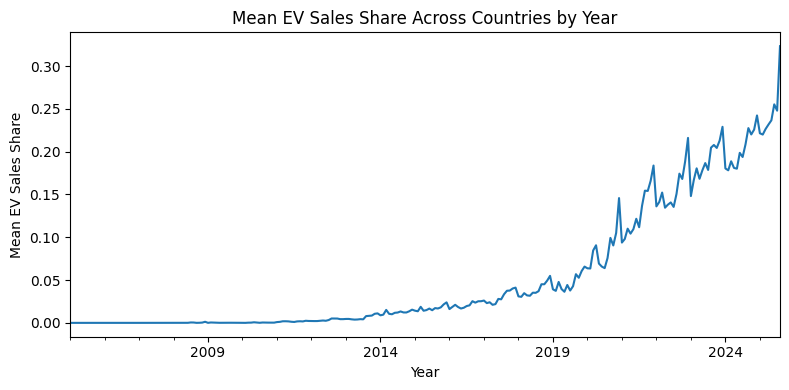

In [4]:
# Calculate mean ev_sales_share across countries for each year
ev_sales_share_mean = (
    e_car_sales[ev.SALES_SHARE_EVS]
    .groupby(level=1)
    .mean()
    .sort_index()
    .to_frame(name='mean_ev_sales_share')
)

# Display the aggregated data
ev_sales_share_mean

# Plot the yearly mean ev_sales_share
ax = ev_sales_share_mean.plot(figsize=(8, 4), legend=False)
ax.set_title('Mean EV Sales Share Across Countries by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Mean EV Sales Share')
plt.tight_layout()
plt.show()


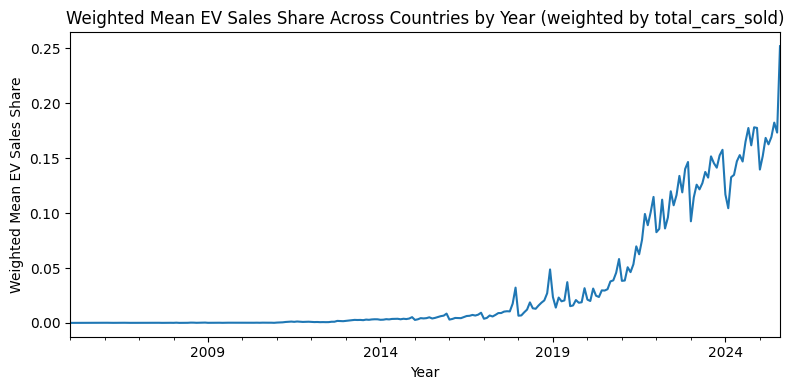

In [5]:
only_countries = e_car_sales[ev.ENTITY_TYPE] == ev.EntityType.Country

weighted_ev_sales_share_mean = (
        (e_car_sales[only_countries][ev.SALES_SHARE_BEVS] * e_car_sales[only_countries][ev.SALES_TOTAL])
        .groupby(level=1)
        .sum()
        /
        e_car_sales[only_countries][ev.SALES_TOTAL].groupby(level=1).sum()
).sort_index().to_frame(name='weighted_mean_ev_sales_share')

weighted_ev_sales_share_mean

ax = weighted_ev_sales_share_mean.plot(figsize=(8, 4), legend=False)
ax.set_title('Weighted Mean EV Sales Share Across Countries by Year (weighted by total_cars_sold)')
ax.set_xlabel('Year')
ax.set_ylabel('Weighted Mean EV Sales Share')
plt.tight_layout()
plt.show()

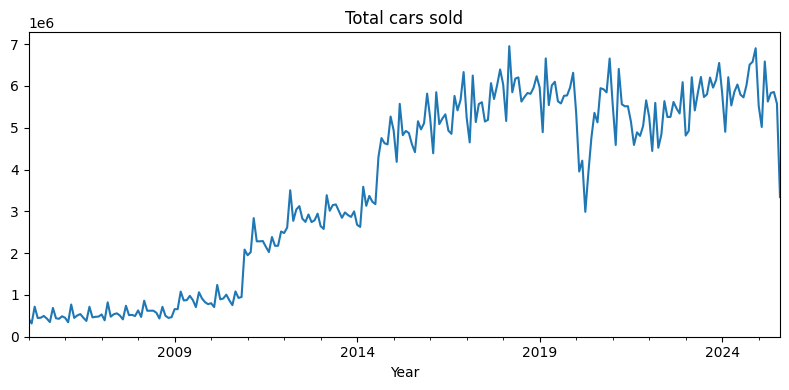

In [6]:


ax = e_car_sales[only_countries][ev.SALES_TOTAL].groupby(level=1).sum().plot(figsize=(8, 4), legend=False)
ax.set_title('Total cars sold')
ax.set_xlabel('Year')
ax.set_ylim(0)
plt.tight_layout()
plt.show()


if 'World' in e_car_sales.index.get_level_values(0):
    ax = e_car_sales.loc['World'][ev.SALES_TOTAL].plot(figsize=(8, 4), legend=False)
    ax.set_title('Total cars sold')
    ax.set_xlabel('Year')
    ax.set_ylim(0)
    plt.tight_layout()
    plt.show()

In [7]:

if 'World' in e_car_sales.index.get_level_values(0):
    ax = e_car_sales.loc['World'][ev.SALES_SHARE_BEVS].plot(figsize=(8, 4), legend=False)
    ax.set_title('EV Sales Share')
    ax.set_xlabel('Year')
    ax.set_ylabel('EV Sales Share')
    plt.tight_layout()
    plt.show()

Offset: 0 before 2005-01-01 00:00:00 after 2005-01-01 00:00:00
Offset: -28 before 2005-01-01 00:00:00 after 1998-01-01 00:00:00
Offset: -28 before 2005-01-01 00:00:00 after 1998-01-01 00:00:00
Offset: -28 before 2005-01-01 00:00:00 after 1998-01-01 00:00:00
Offset: -28 before 2005-01-01 00:00:00 after 1998-01-01 00:00:00
Offset: -28 before 2005-01-01 00:00:00 after 1998-01-01 00:00:00
Offset: -28 before 2005-01-01 00:00:00 after 1998-01-01 00:00:00
Offset: -28 before 2005-01-01 00:00:00 after 1998-01-01 00:00:00
Offset: -28 before 2005-01-01 00:00:00 after 1998-01-01 00:00:00
Offset: -28 before 2005-01-01 00:00:00 after 1998-01-01 00:00:00
Time shift of all the countries (how many years they are ahead / behind the average transition)


{'Albania': -19,
 'Australia': -11,
 'Austria': 2,
 'Belgium': 5,
 'Brazil': -20,
 'Bulgaria': -14,
 'California': 2,
 'Canada': -6,
 'Chile': -28,
 'China': 6,
 'Colombia': -18,
 'Croatia': -15,
 'Cyprus': -10,
 'Czechia': -18,
 'Denmark': 10,
 'Estonia': -11,
 'Finland': 10,
 'France': 1,
 'Germany': 4,
 'Greece': -10,
 'Hungary': -10,
 'Iceland': 17,
 'India': -21,
 'Indonesia': -10,
 'Ireland': 6,
 'Israel': 2,
 'Italy': -10,
 'Japan': -22,
 'Latvia': -9,
 'Lithuania': -10,
 'Luxembourg': 5,
 'Malaysia': -20,
 'Malta': 4,
 'Mexico': -26,
 'Netherlands': 6,
 'New Zealand': -10,
 'Norway': 33,
 'Poland': -14,
 'Portugal': 2,
 'Romania': -11,
 'Singapore': 3,
 'Slovakia': -16,
 'Slovenia': -10,
 'Spain': -10,
 'Sweden': 13,
 'Switzerland': 4,
 'Taiwan': -10,
 'Thailand': -7,
 'Turkey': -8,
 'USA': -10,
 'United Kingdom': 2,
 'Uruguay': -6}

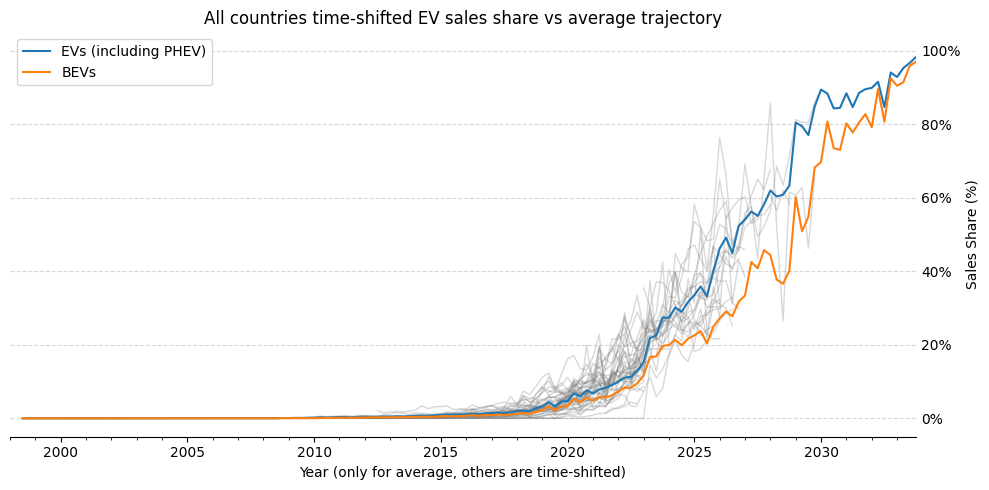

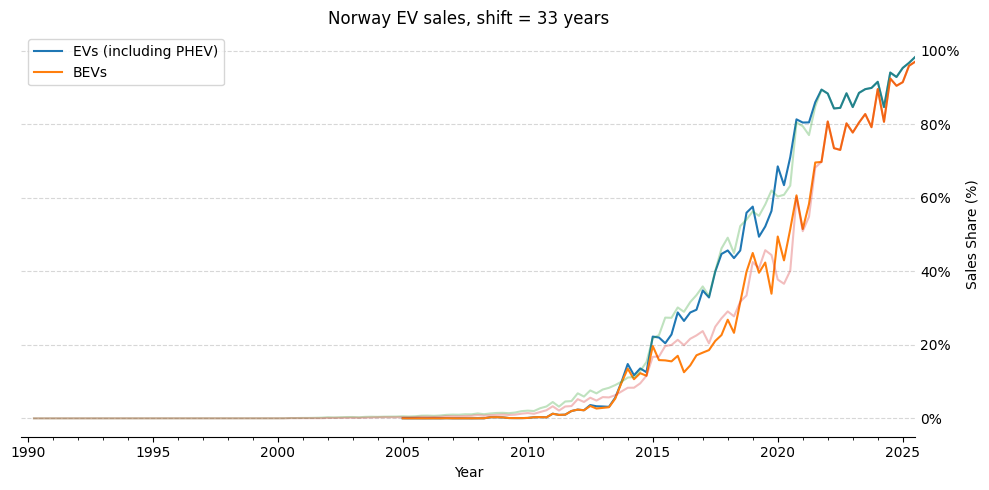

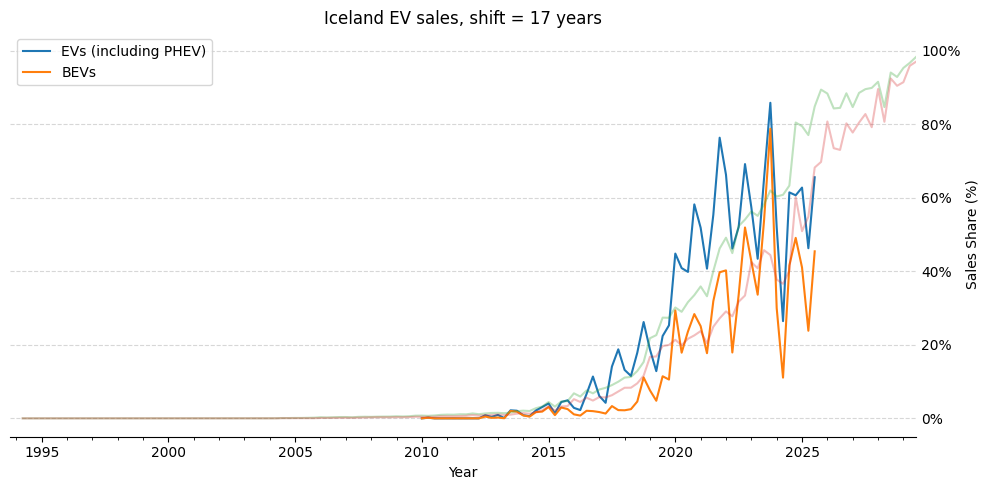

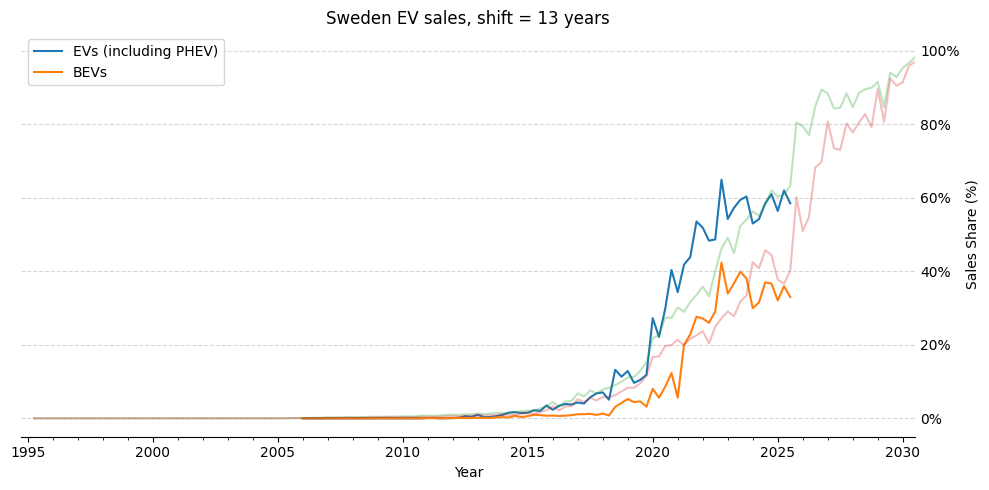

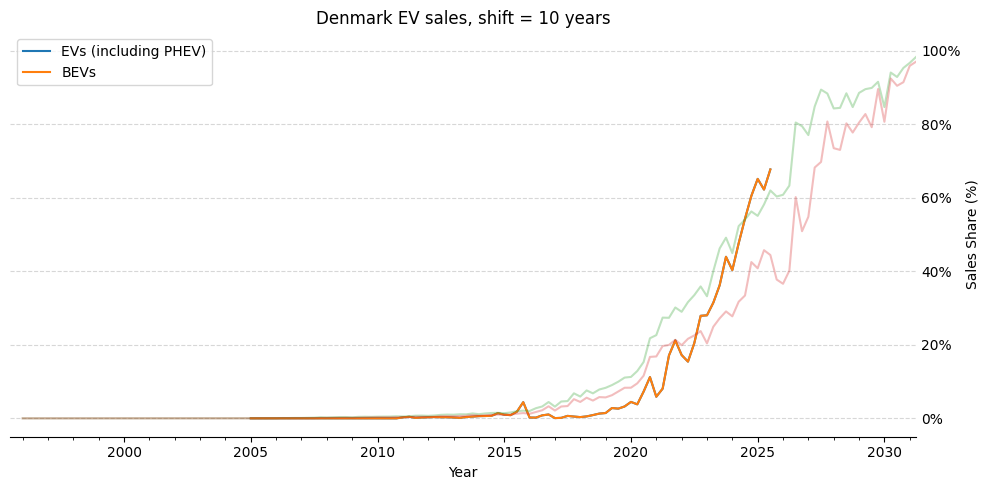

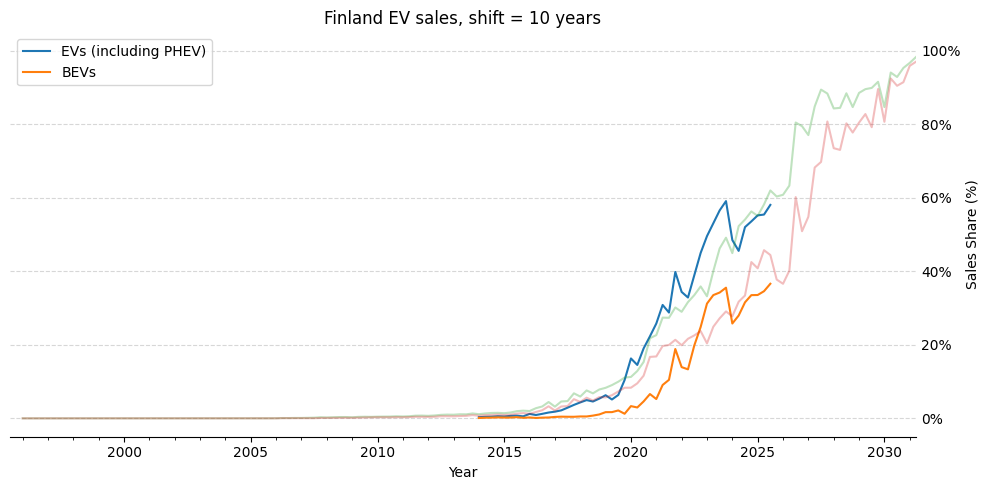

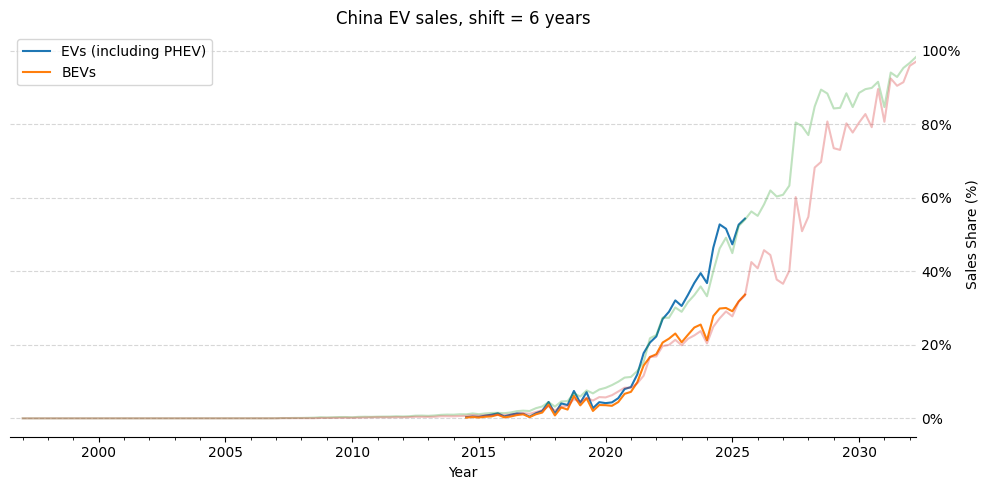

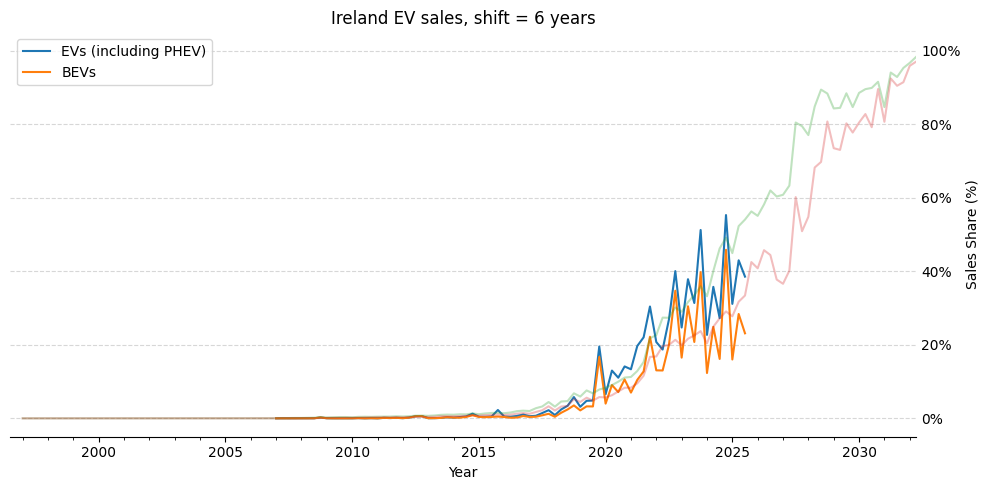

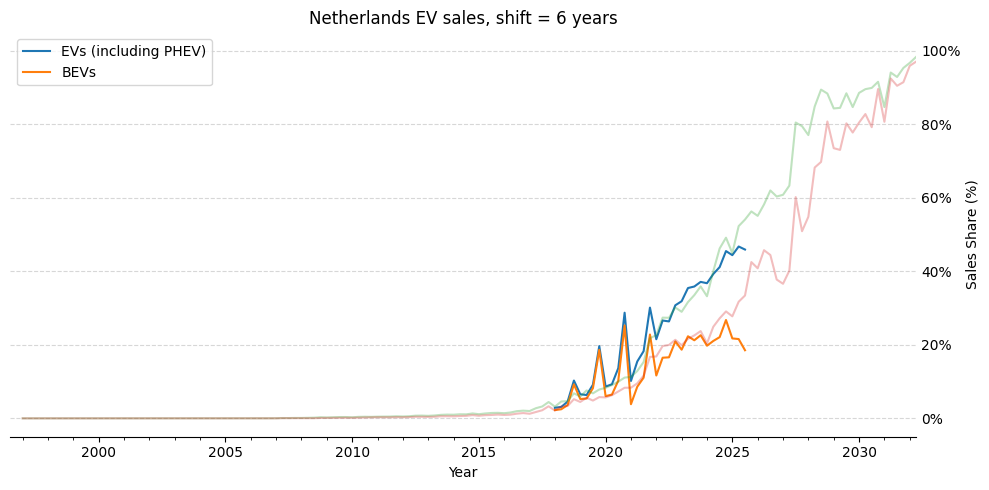

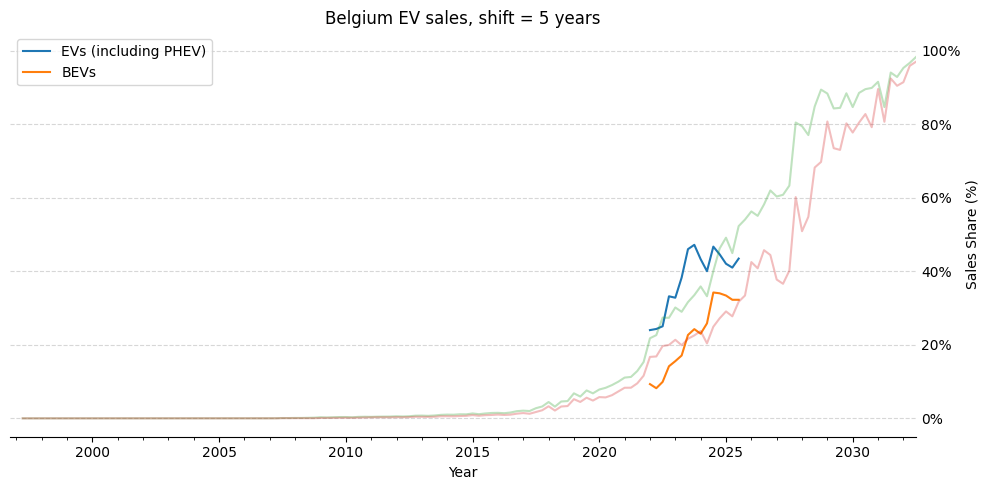

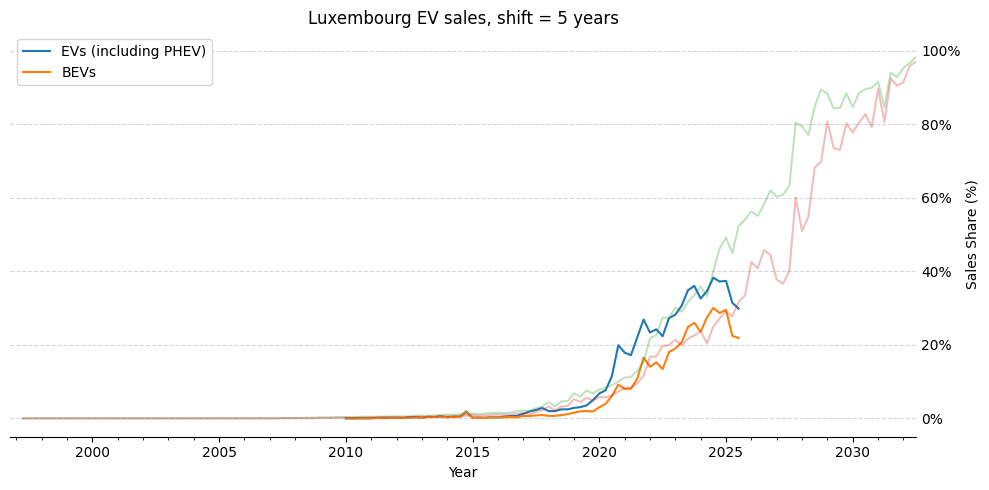

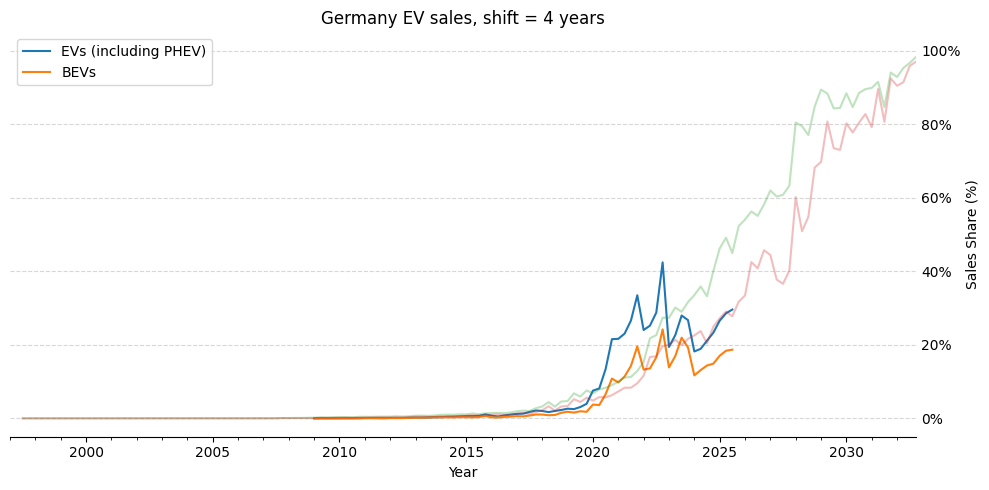

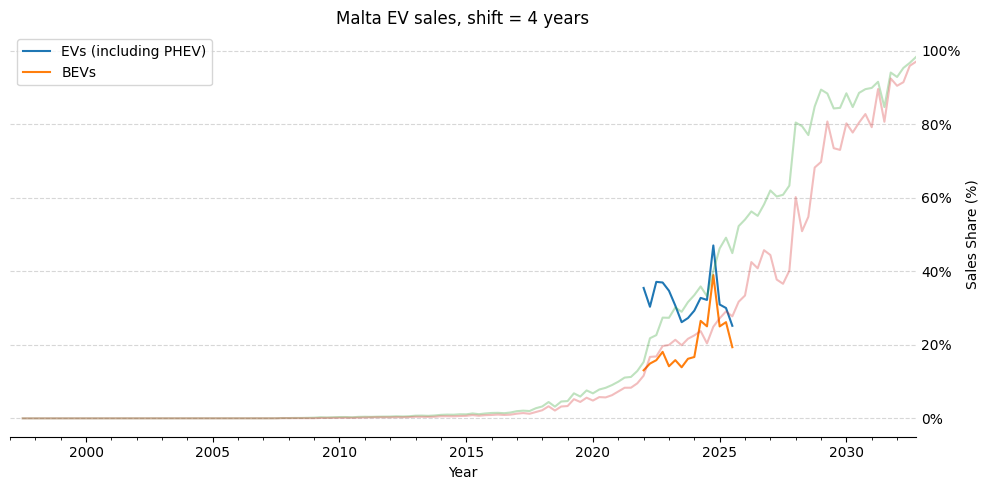

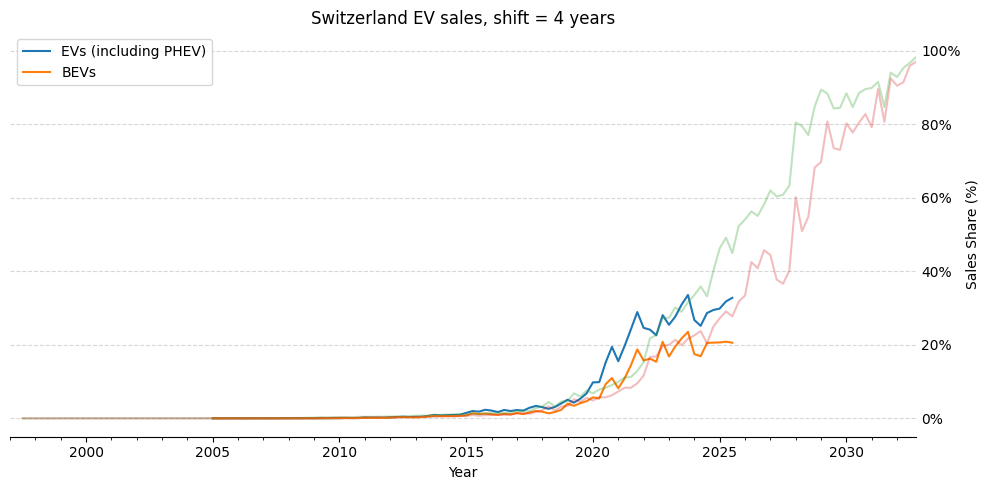

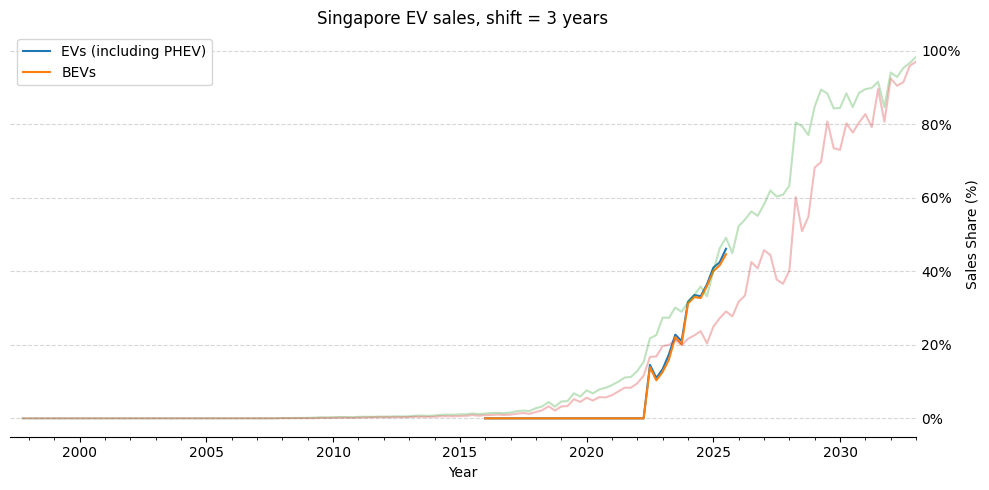

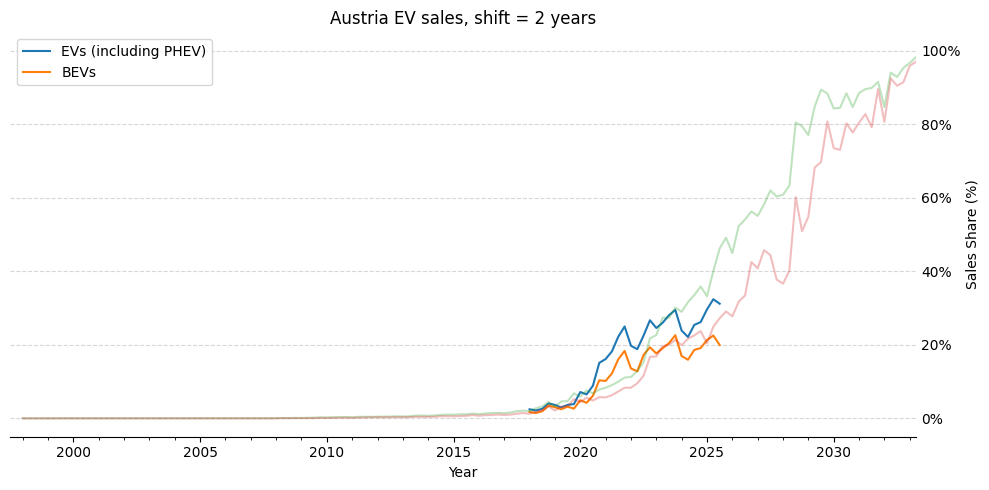

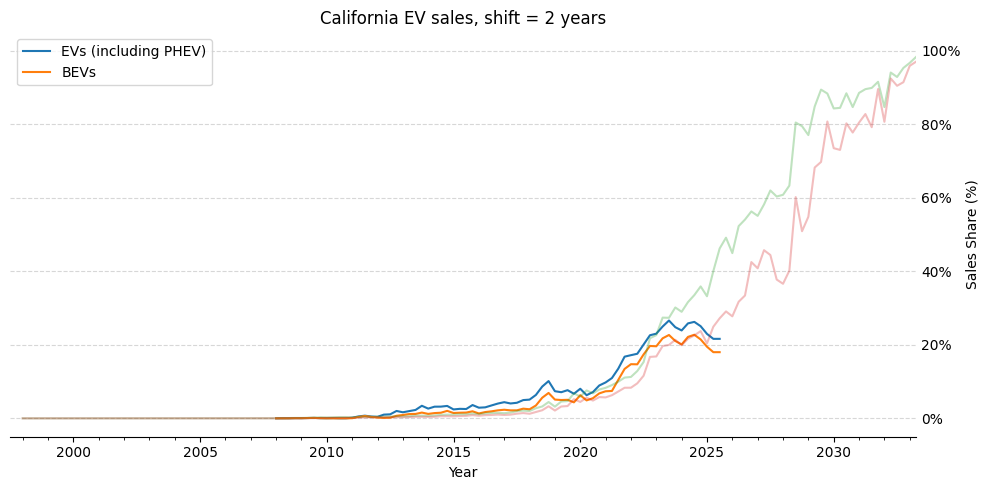

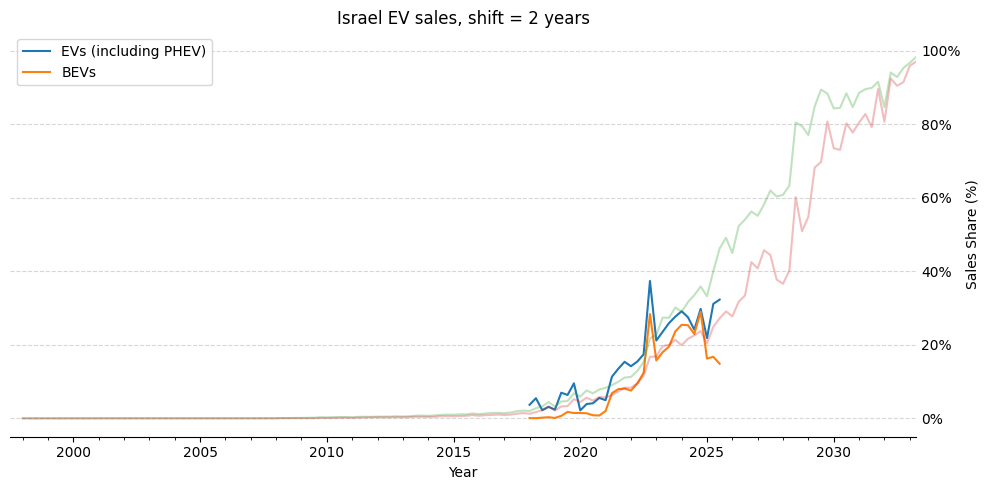

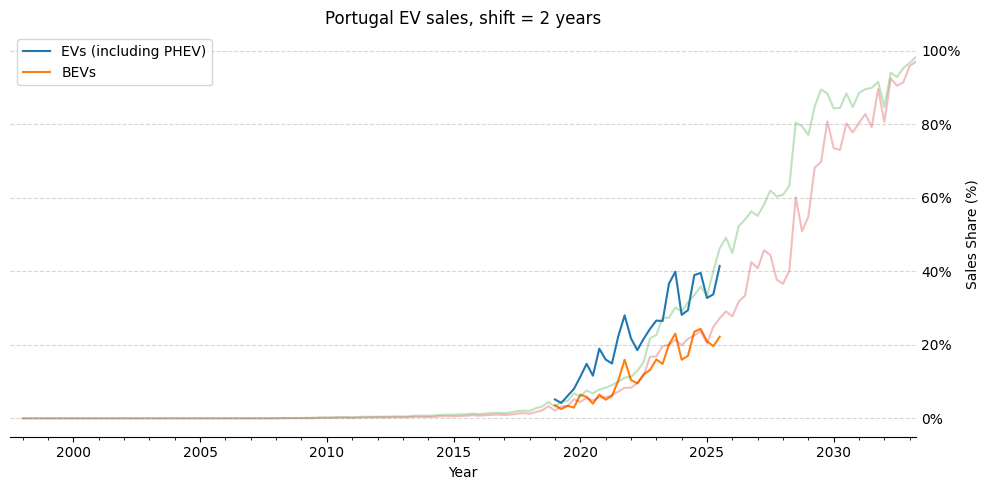

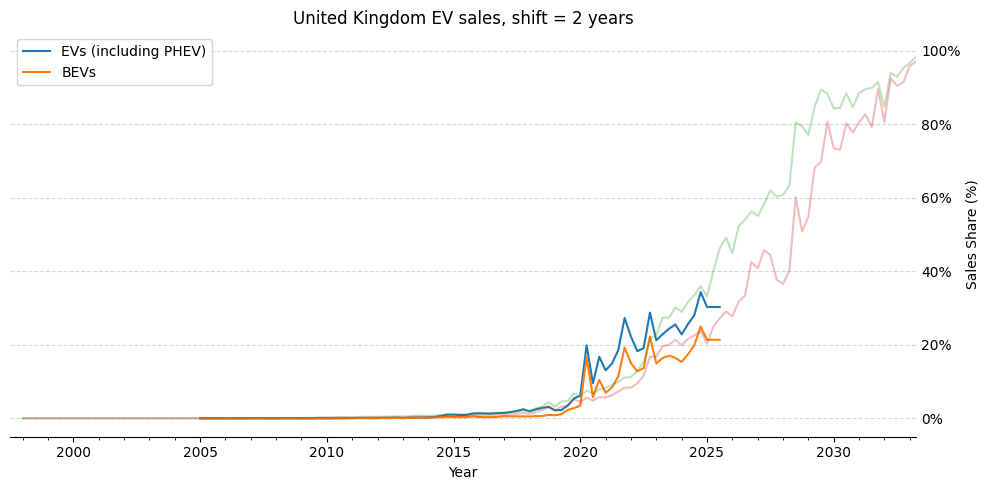

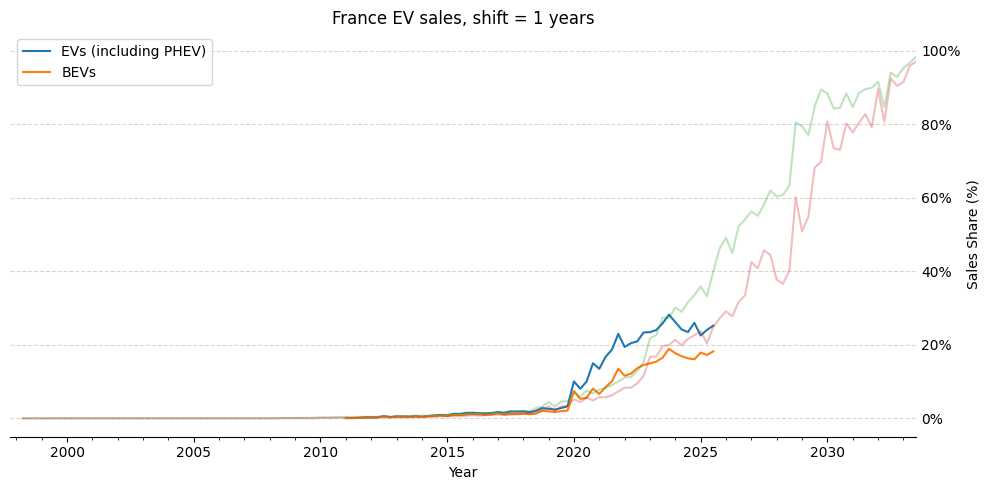

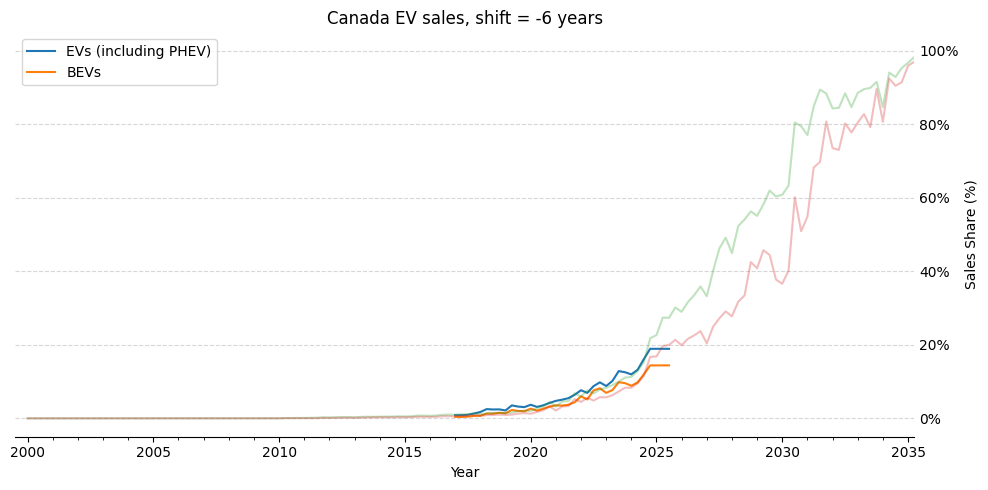

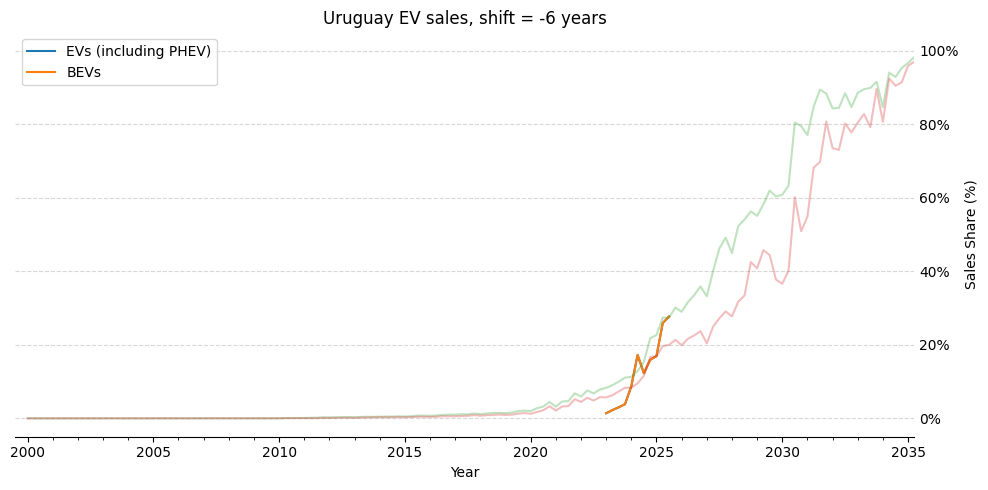

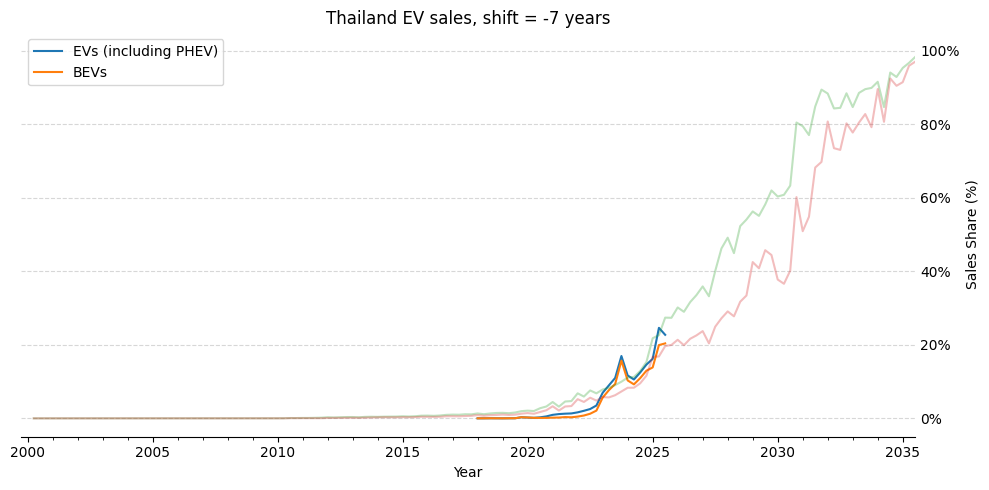

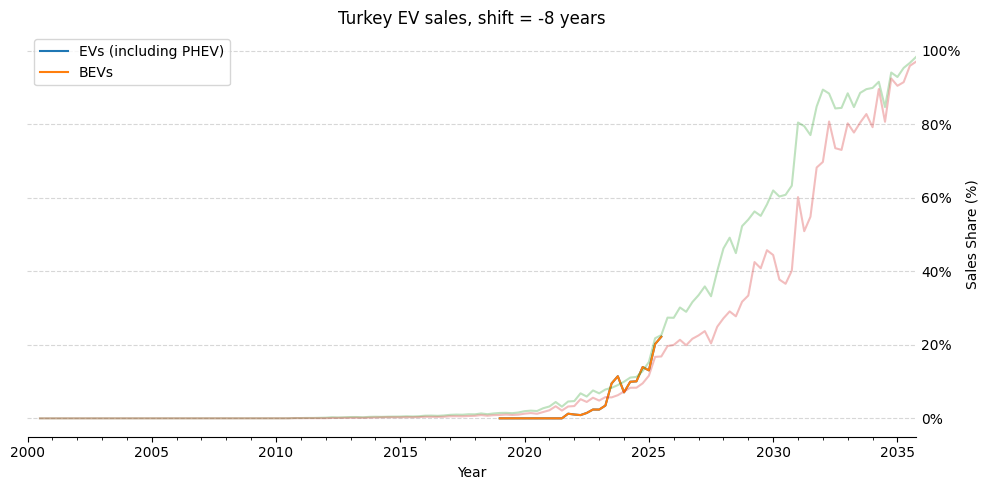

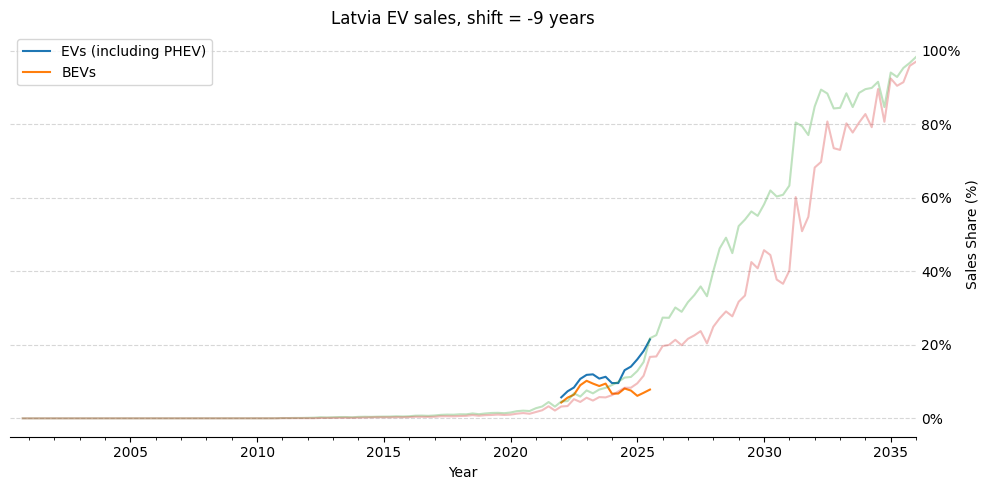

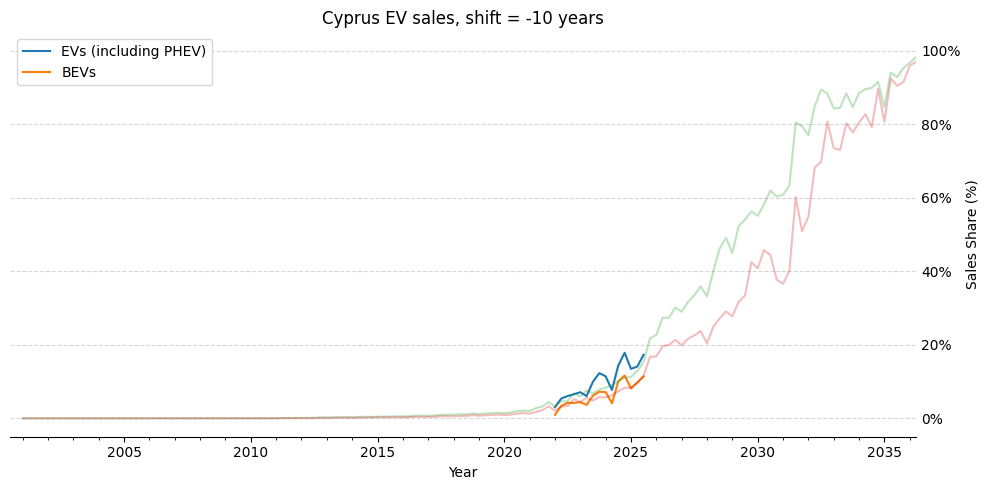

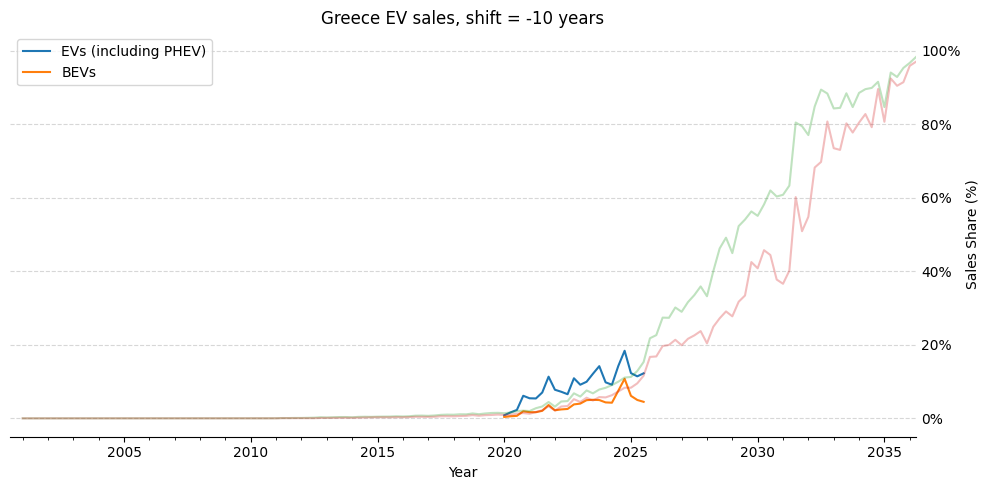

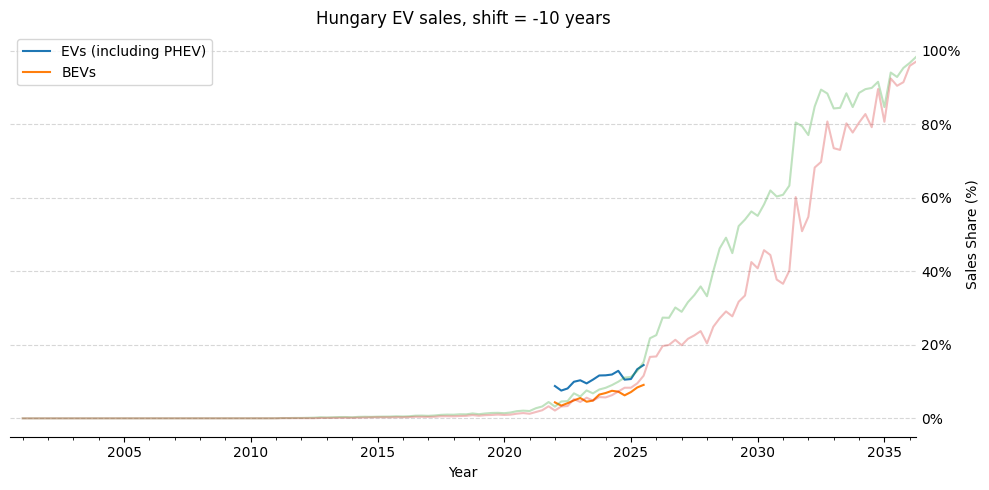

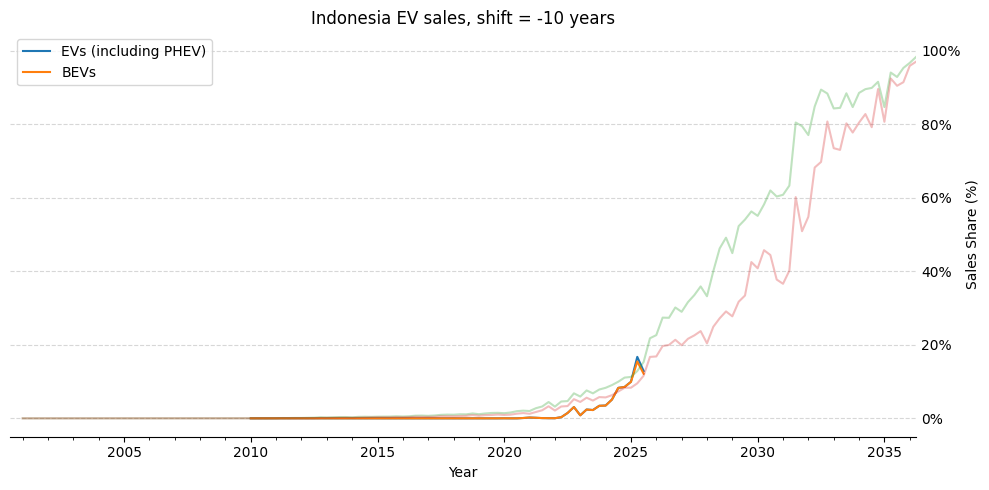

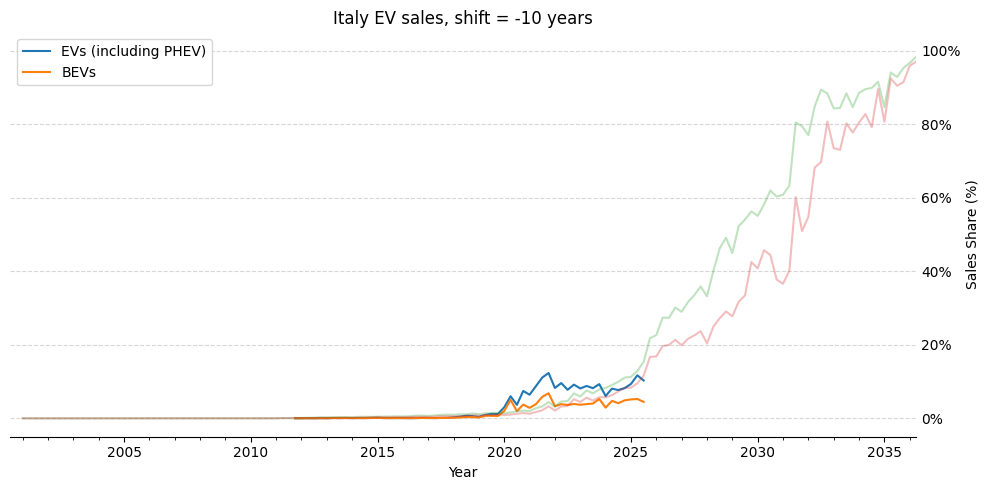

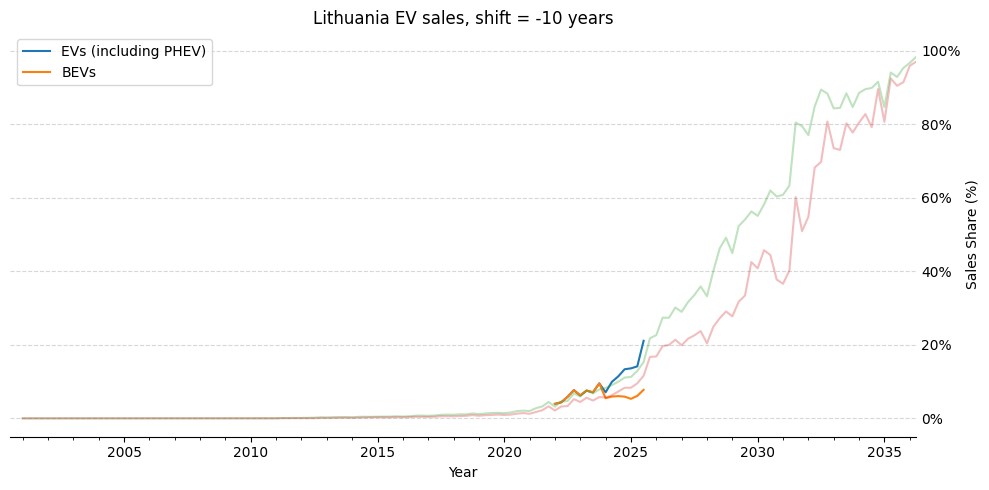

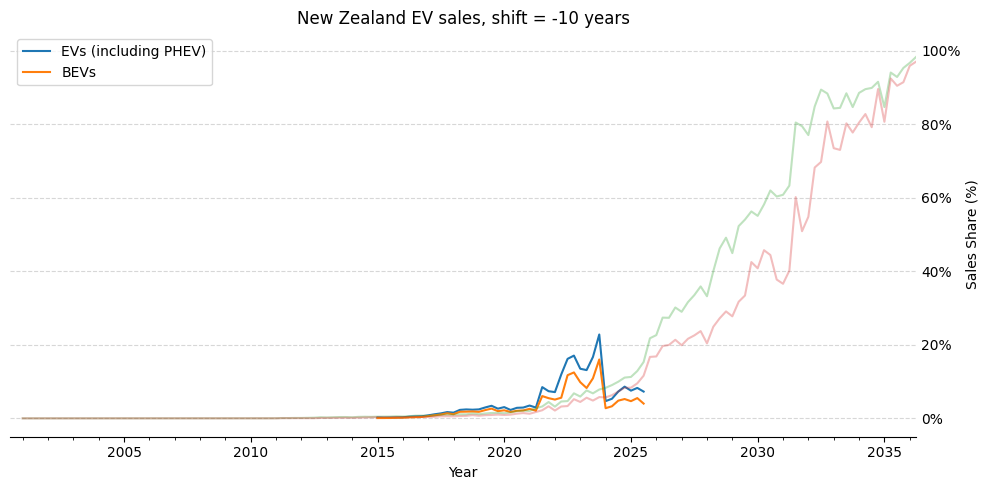

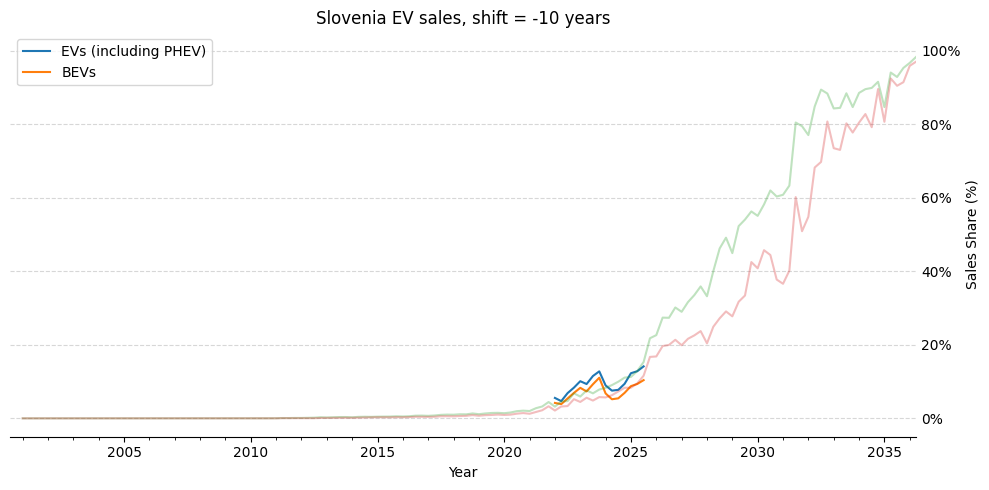

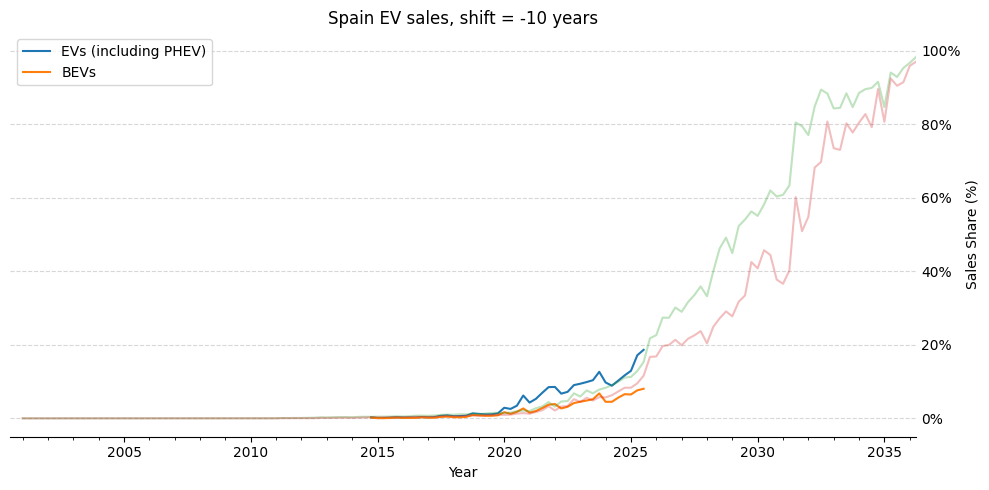

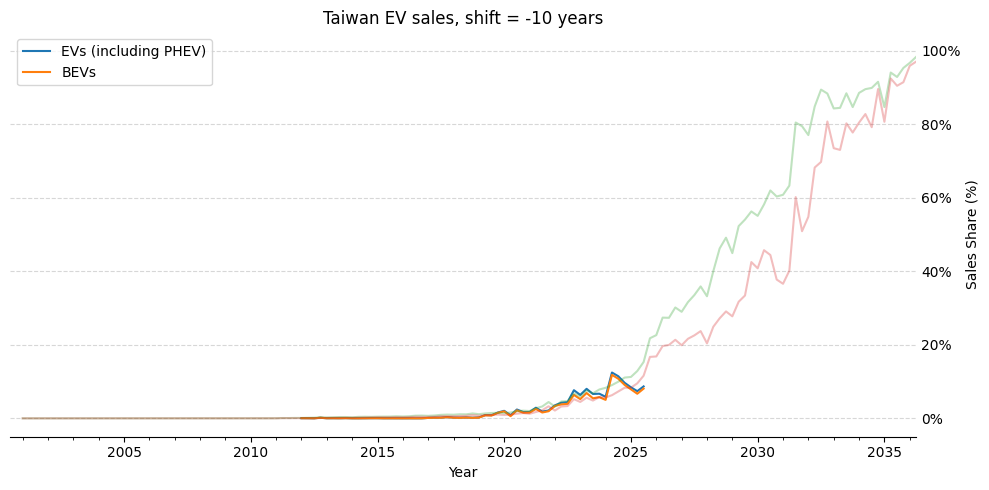

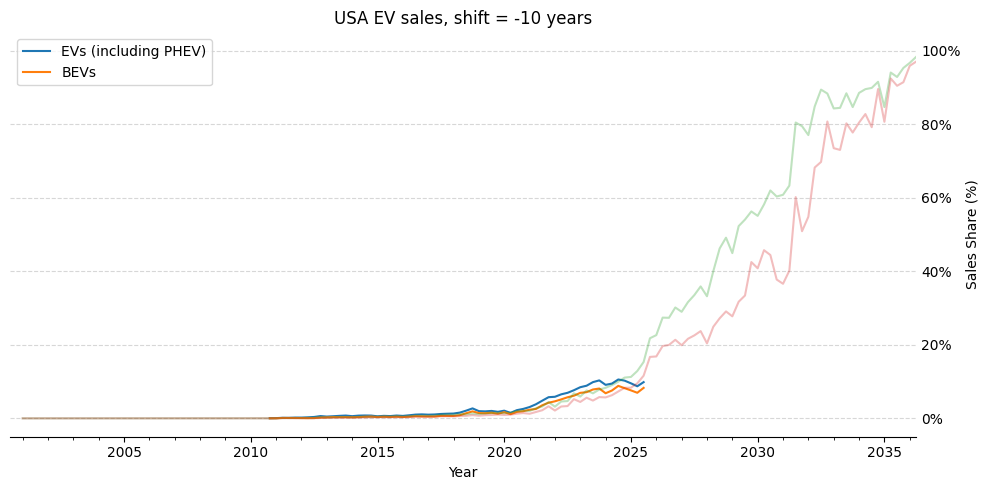

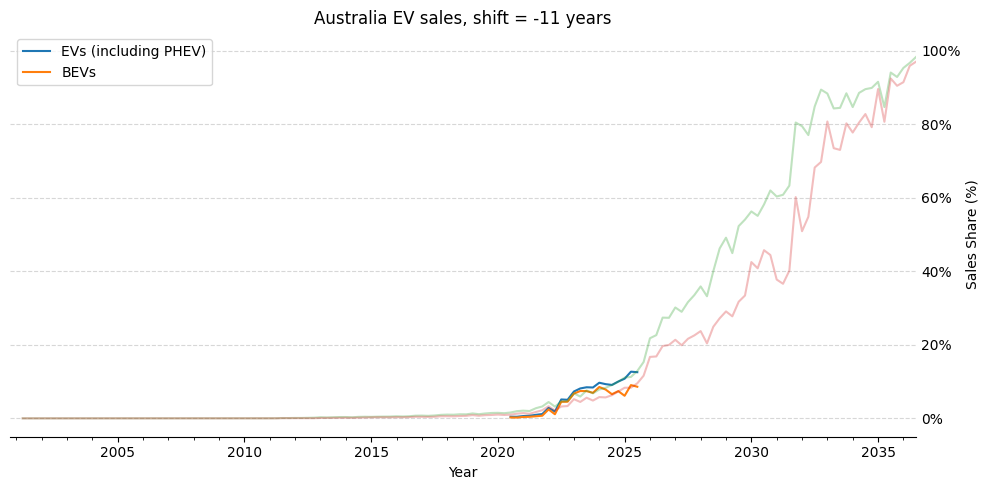

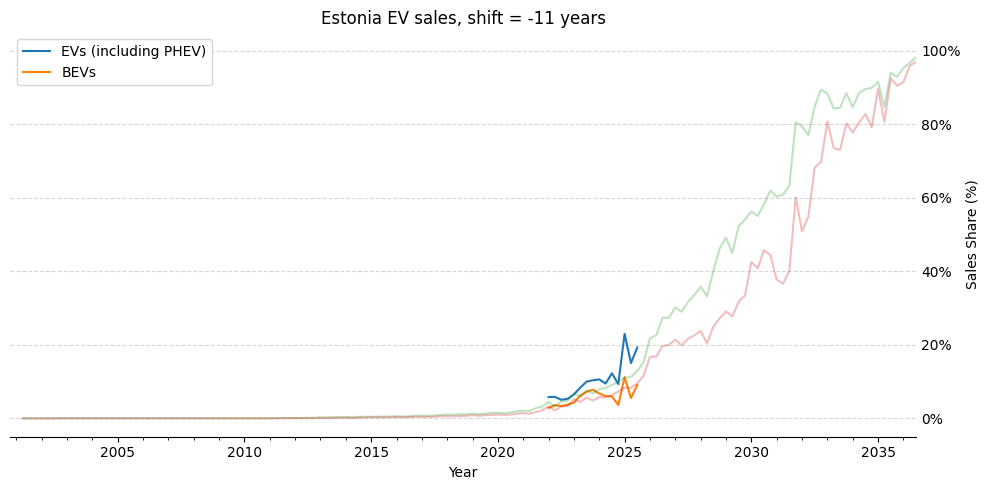

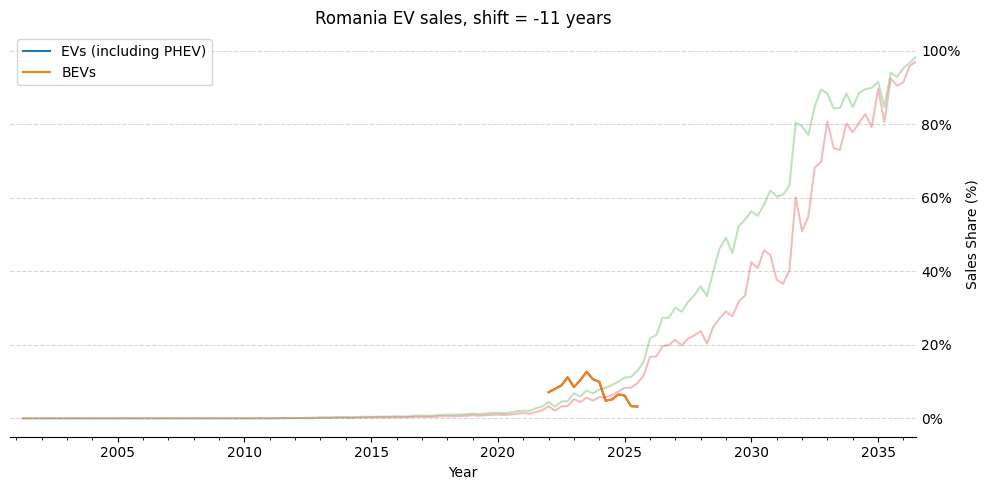

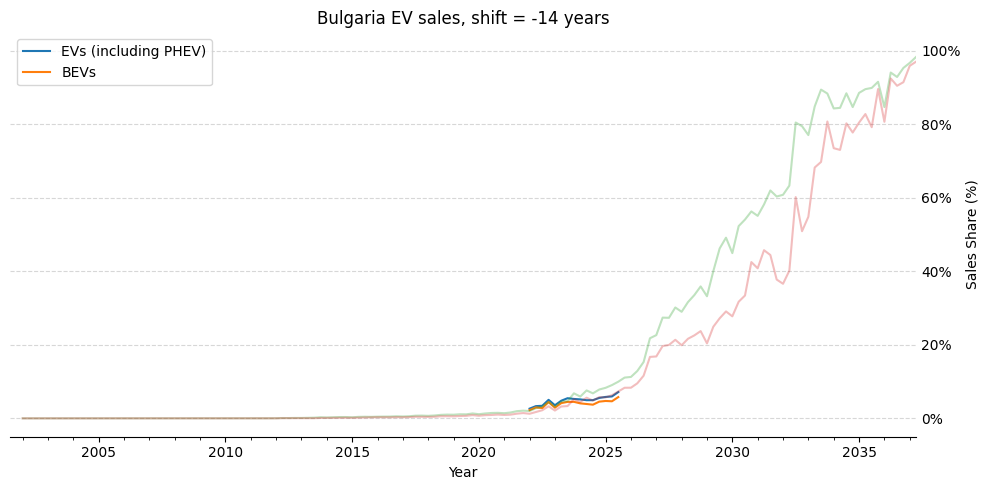

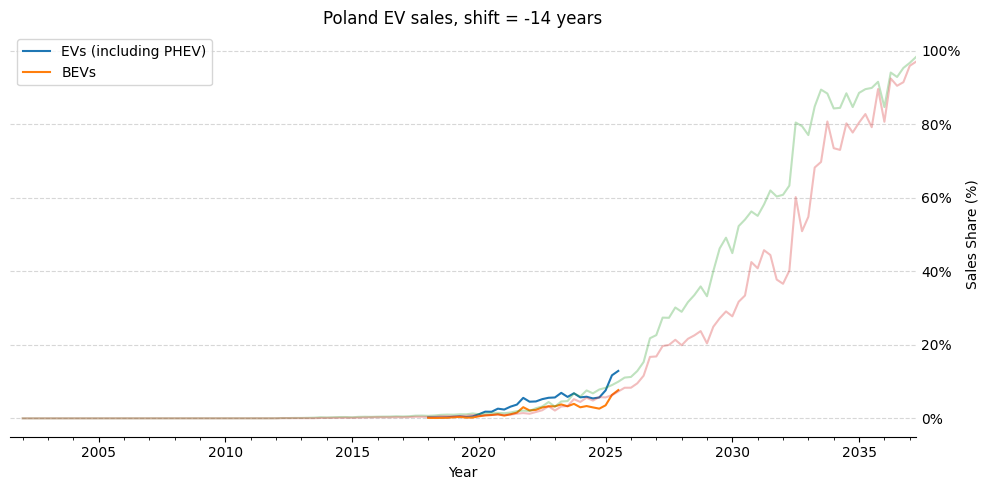

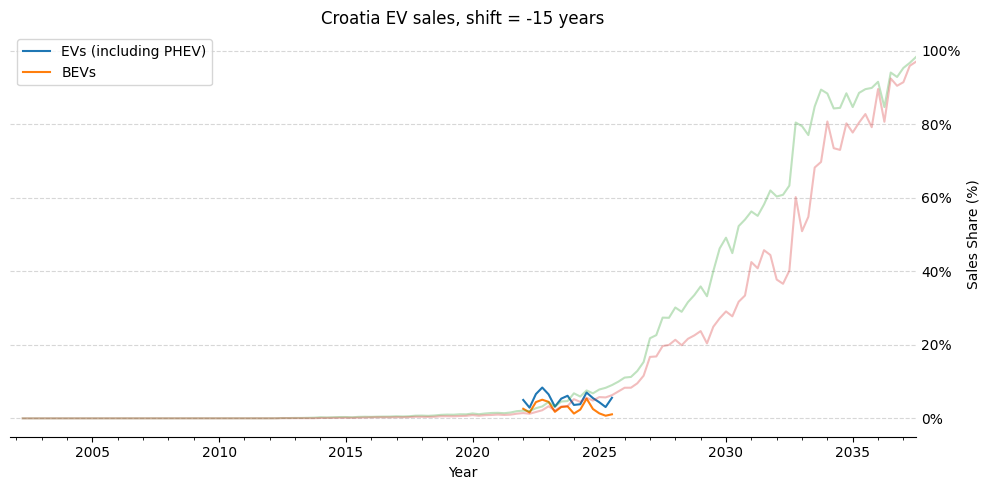

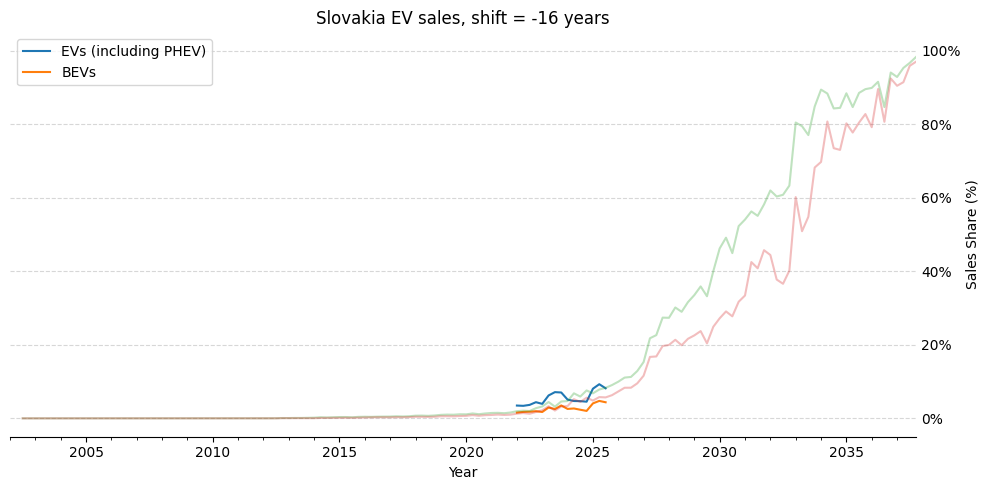

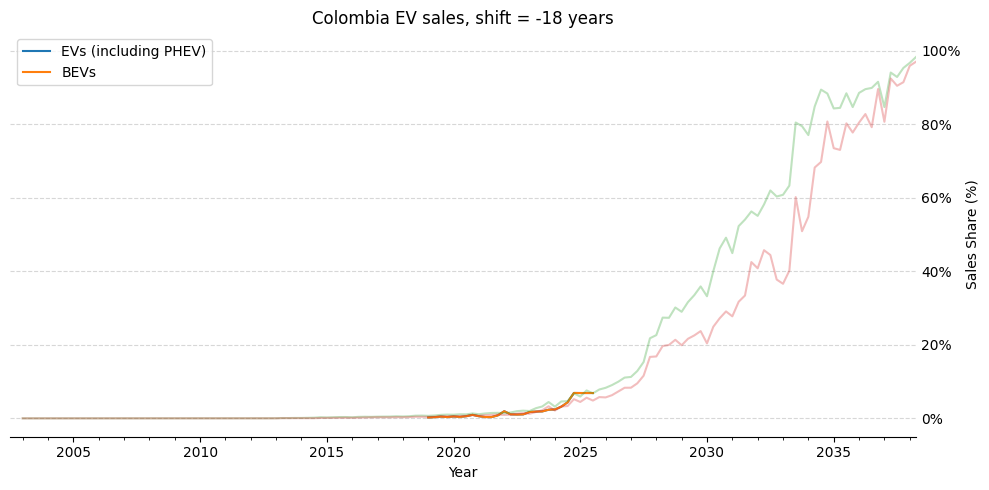

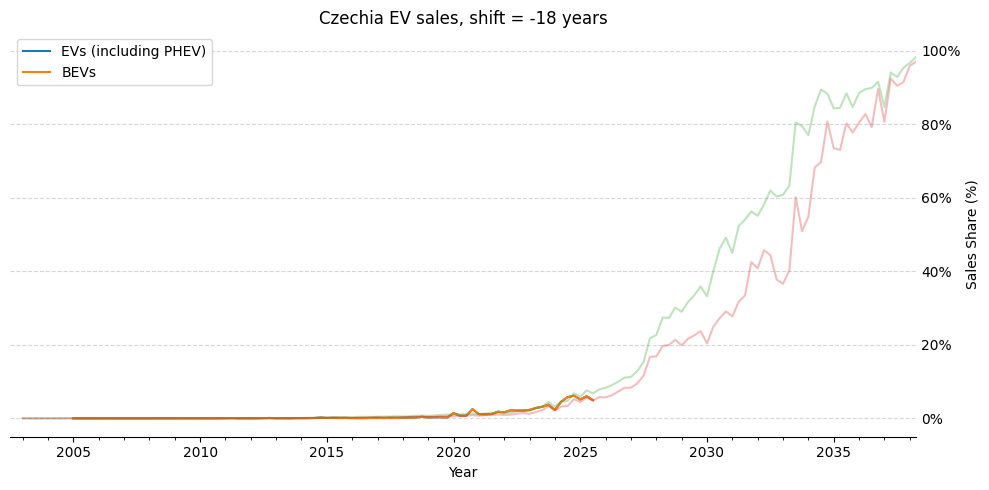

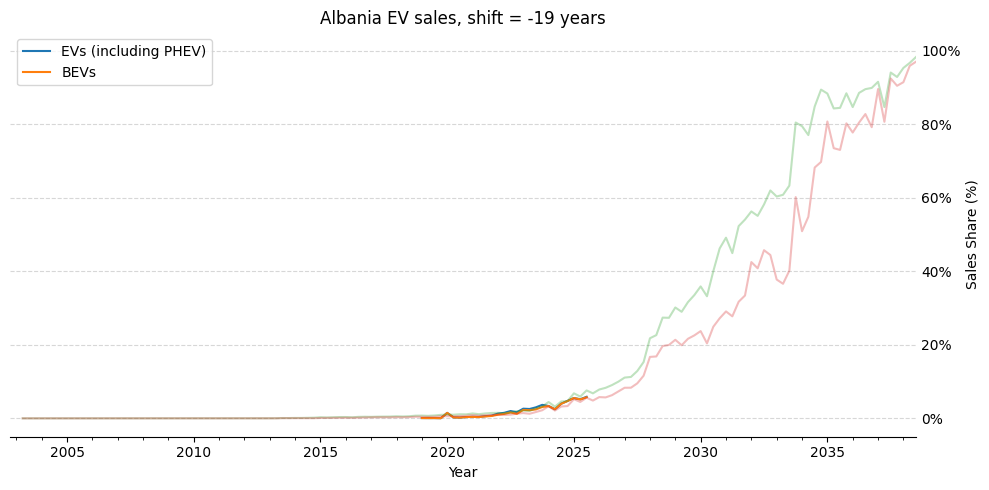

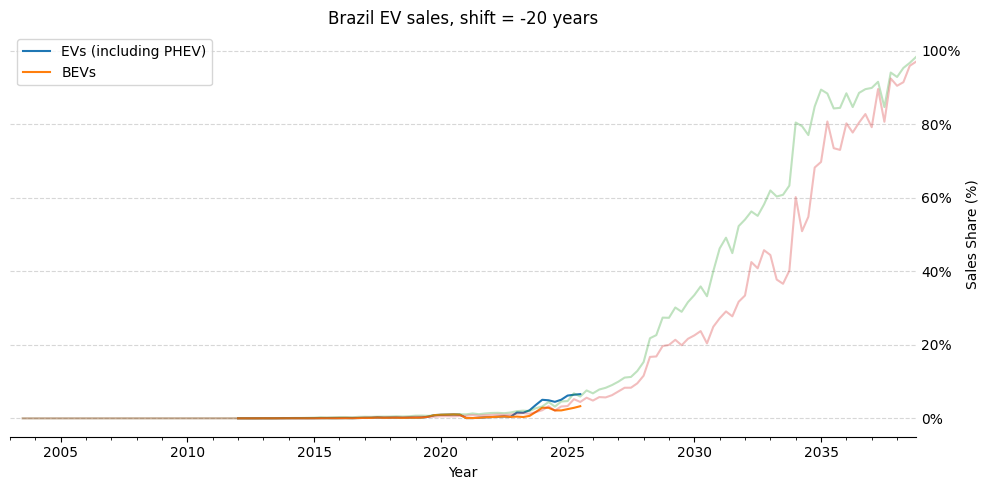

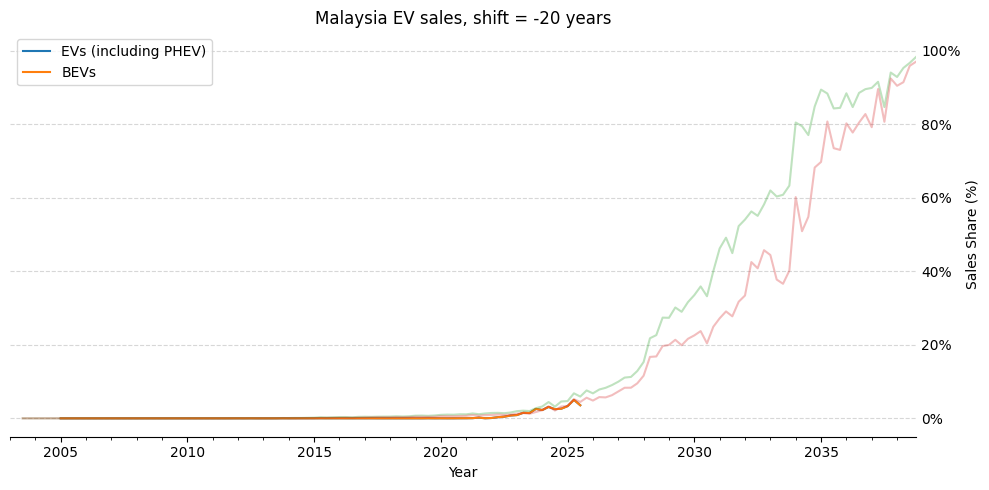

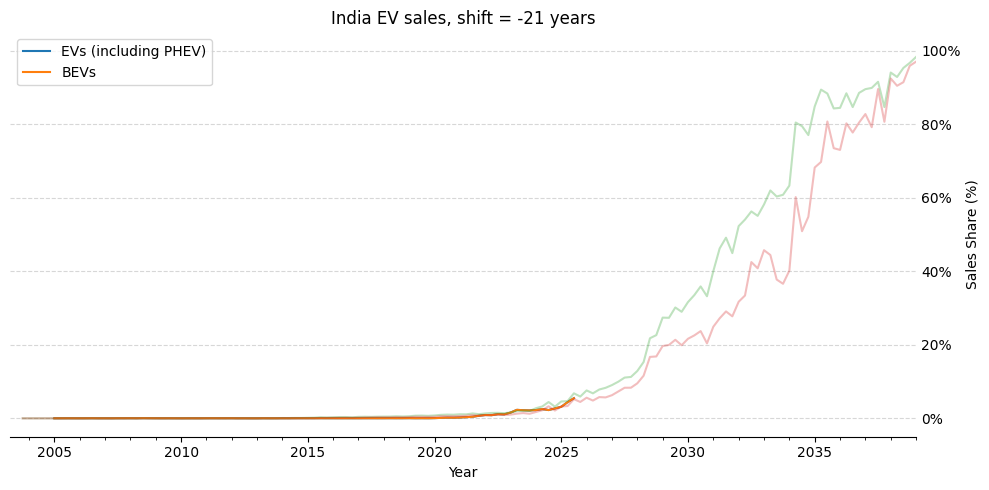

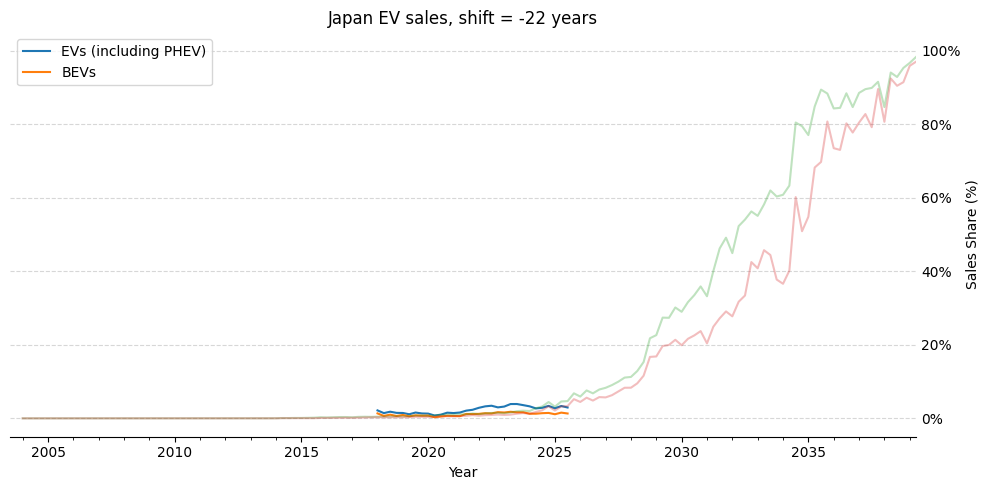

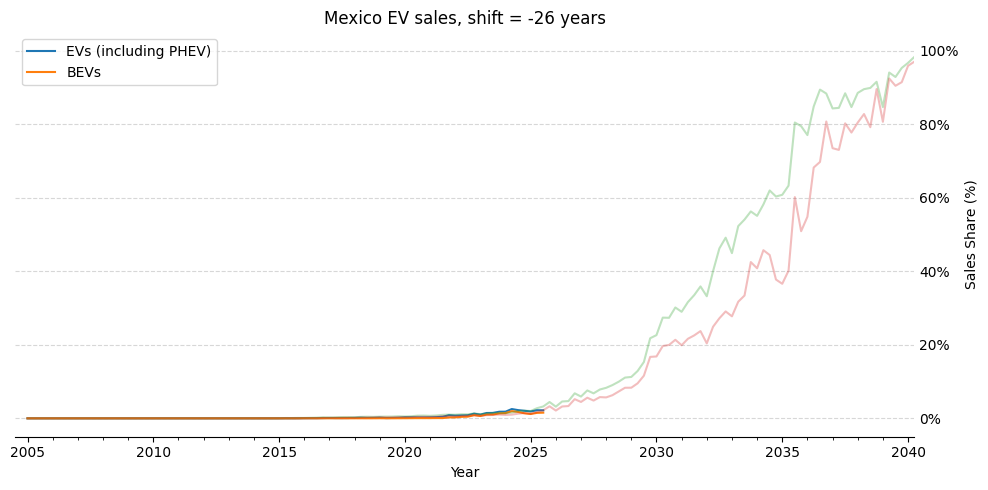

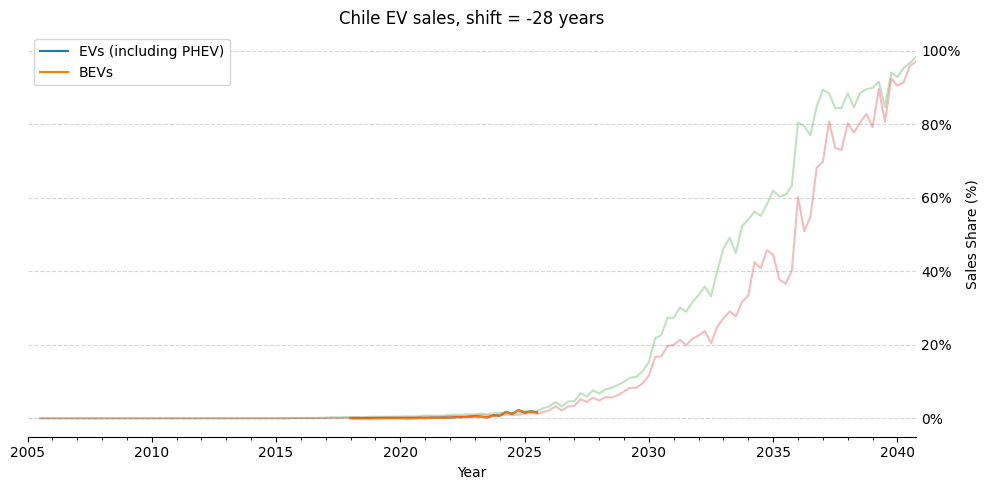

In [8]:


frequency = pd.infer_freq(e_car_sales.index.get_level_values(1).unique().sort_values())
if frequency is None:
    print('Falling back to default frequency: Monthly')
    frequency = 'MS'
frequency = 'QS'

# make sure all the data conforms to the frequency we want
relevant_sales = e_car_sales[only_countries]
countries = relevant_sales.index.get_level_values(0).unique()
dates = relevant_sales.index.get_level_values(1).unique().sort_values()
min_date, max_date = dates.min(), dates.max()
dates_index = pd.date_range(min_date, max_date, freq=frequency, normalize=True)
min_date, max_date = dates_index.min(), dates_index.max()
#relevant_sales = relevant_sales.reindex(pd.MultiIndex.from_product([countries, dates_index], names=relevant_sales.index.names))
relevant_sales = relevant_sales.groupby(level=0, group_keys=True).apply(
    lambda g: g.droplevel(0).sort_index().resample(frequency).mean(numeric_only=True).reindex(dates_index).interpolate(
        method='time')).reindex(pd.MultiIndex.from_product([countries, dates_index], names=relevant_sales.index.names))


# How many years each country is ahead / behind
countries_offsets = {c: 0 for c in relevant_sales.index.get_level_values(0).unique()}

for i in range(10):
    
    min_off = min(min(countries_offsets.values()), 0)
    max_off = max(max(countries_offsets.values()), 0)
    #start_date = min_date + pd.Timedelta(min_off, unit=frequency)
    # this seems to be the best method to add a certain number of `frequency` to a given date...
    start_date = pd.date_range(
        end = min_date, 
        periods = -min_off+1, 
        freq = frequency
    )[0]
    print('Offset:', min_off, 'before', min_date, 'after', start_date)
    #end_date = max_date + pd.Timedelta(max_off + 1, unit=frequency)
    end_date = pd.date_range(
        start = max_date, 
        periods = max_off+1, 
        freq = frequency
    )[-1]
    expanded_dates = pd.date_range(start_date, end_date, freq=frequency)

    expanded_index = pd.MultiIndex.from_product([countries, expanded_dates], names=relevant_sales.index.names)
    
    #print(expanded_index)
    
    # shift the sales data in every country by the years in country_offsets
    shifted_sales = (
        relevant_sales.reindex(expanded_index)
        .groupby(level=0, group_keys=False)
        .apply(lambda g: g.sort_index(level=1).shift(countries_offsets.get(g.index.get_level_values(0)[0], 0)))
    )
    
    if(shifted_sales.index.get_level_values(1).unique().sort_values().min() != start_date):
        print('Error: shifted sales index does not start at the start date')

    # includes PHEV
    mean_ev_sales_share = (
            (shifted_sales[ev.SALES_SHARE_EVS] * shifted_sales[ev.SALES_TOTAL])
            .groupby(level=1).sum()
            /
            shifted_sales[ev.SALES_TOTAL].groupby(level=1).sum()
    ).sort_index().to_frame(name='EV')

    mean_bev_sales_share = (
            (shifted_sales[ev.SALES_SHARE_BEVS] * shifted_sales[ev.SALES_TOTAL])
            .groupby(level=1).sum()
            /
            shifted_sales[ev.SALES_TOTAL].groupby(level=1).sum()
    ).sort_index().to_frame(name='BEV')
    


    a_ev = mean_ev_sales_share['EV'].to_numpy()
    a_bev = mean_bev_sales_share['BEV'].to_numpy()
    for c in countries_offsets:
        v_ev = relevant_sales[ev.SALES_SHARE_EVS].loc[c].to_numpy()
        v_bev = relevant_sales[ev.SALES_SHARE_BEVS].loc[c].to_numpy()
        
        assert len(v_ev) == len(v_bev)
        c_start_date = relevant_sales[ev.SALES_SHARE_BEVS].loc[c].index.min()
        
        base_offset = -len(pd.date_range(
            start = start_date, 
            end = c_start_date, 
            freq = frequency
        )) 
        
        # offsets should be the same
        offsets, correlated_ev = correlate_slice_normalized(a_ev, v_ev)
        _, correlated_bev = correlate_slice_normalized(a_bev, v_bev)
        
        # consider correlation of both EV (includes PHEV) and BEV fractions 
        correlated = (correlated_ev + correlated_bev) / 2 #- abs(offsets+base_offset) * 0.
        
        new_shift = offsets[np.argmax(correlated)] + base_offset
        countries_offsets[c] = new_shift
        
        # Debug info for specific countries
        if c in []:
            print('Country data start date: ', c_start_date)
            print('Global data start date: ', start_date)
            print('Global data end date: ', end_date)
            print('Base offset: ', base_offset, 'Calculated Shift: ', new_shift)
            ax = pd.concat([relevant_sales.loc[c][ev.SALES_SHARE_EVS], relevant_sales.loc[c][ev.SALES_SHARE_BEVS]], axis=1).plot(figsize=(8, 4), legend=False)
            ax = pd.concat([mean_ev_sales_share, mean_bev_sales_share], axis=1).plot(ax=ax, figsize=(8, 4), legend=True, alpha=0.3)
            ax.set_title('EV Sales Share')
            ax.set_xlabel('Year')
            ax.set_ylabel('EV Sales Share')
            plt.tight_layout()
            plt.show()
        
            corr_series = pd.concat([
                pd.Series(correlated, name='Correlation'),
                pd.Series(correlated_ev, name='EV'),
                pd.Series(correlated_bev, name='BEV')
                ], axis=1)
            ax = corr_series.plot(figsize=(8, 2))
            ax.set_title(f'Correlation of {c}')
            plt.tight_layout()
            plt.show()
            
            print('Different maxima: ', np.argmax(correlated), new_shift, offsets[np.argmax(correlated_ev)] + base_offset, offsets[np.argmax(correlated_bev)] + base_offset)
            
            ax = pd.concat([relevant_sales.loc[c][ev.SALES_SHARE_EVS], relevant_sales.loc[c][ev.SALES_SHARE_BEVS]], axis=1).shift(new_shift, freq=frequency).plot(figsize=(8, 4), legend=False)
            ax = pd.concat([mean_ev_sales_share, mean_bev_sales_share], axis=1).plot(ax=ax, figsize=(8, 4), legend=True, alpha=0.3)
            ax.set_title(f'{c}, Shift = {new_shift}')
            ax.set_xlabel('Year')
            ax.set_ylabel('EV Sales Share')
            plt.tight_layout()
            plt.show()


print('Time shift of all the countries (how many years they are ahead / behind the average transition)')
display({k: int(v) for k, v in countries_offsets.items()})



ax = shifted_sales[ev.SALES_SHARE_EVS].unstack(level=0).plot(figsize=(10, 5), legend=False, alpha=0.3, color='grey', lw=1)
ax = pd.concat([mean_ev_sales_share, mean_bev_sales_share], axis=1).rename(columns={'EV': 'EVs (including PHEV)', 'BEV': 'BEVs'}).plot(ax = ax, figsize=(10, 5), legend=True)
ax.set_title(f'All countries time-shifted EV sales share vs average trajectory')
ax.set_xlabel('Year (only for average, others are time-shifted)')
ax.set_ylabel('Sales Share (%)')
ax.set_ylim(-0.05, 1.05)
ax.yaxis.set_label_position("right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.yaxis.tick_right()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
plt.tick_params(axis='y', which='major', length=0)
plt.grid(linestyle='--', alpha=0.5, axis='y')
plt.tight_layout()
#plt.savefig(f'figures/world/ev_trajectories/all_ev_trajectories.png', dpi=300, bbox_inches='tight')
#plt.savefig(f'figures/world/ev_trajectories/all_ev_trajectories.svg', dpi=300, bbox_inches='tight')
plt.show()


for c in sorted(countries_offsets.keys(), key=lambda x: countries_offsets[x], reverse=True):
    ax = relevant_sales.loc[c][ev.SALES_SHARE_EVS].plot(figsize=(10, 5), legend=True, label='EVs (including PHEV)')
    ax = relevant_sales.loc[c][ev.SALES_SHARE_BEVS].plot(ax = ax, figsize=(10, 5), legend=True, label='BEVs')
    ax = pd.concat([mean_ev_sales_share, mean_bev_sales_share], axis=1).shift(-countries_offsets[c], freq=frequency).plot(ax = ax, figsize=(10, 5), alpha=0.3, legend=False)
    ax.set_title(f'{c} EV sales, shift = {countries_offsets[c]} years')
    ax.set_xlabel('Year')
    ax.set_ylabel('Sales Share (%)')
    ax.set_ylim(-0.05, 1.05)
    ax.yaxis.set_label_position("right")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax.yaxis.tick_right()
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    plt.tick_params(axis='y', which='major', length=0)
    plt.grid(linestyle='--', alpha=0.5, axis='y')
    plt.tight_layout()
    #plt.savefig(f'figures/world/ev_trajectories/ev_trajectory_{c}.png', dpi=300, bbox_inches='tight')
    #plt.savefig(f'figures/world/ev_trajectories/ev_trajectory_{c}.svg', dpi=300, bbox_inches='tight')
    plt.show()

TODO: In the future, an S-Curve can be fit to this trajectory and parameters can be extracted to understand the speed of the transition